In [17]:
import numpy as np
import msicpe.san as san
from plotly import express as px
import scipy.signal as signal

DOSSIER_DONNEES = "apprentissage"

# ============================================
#  SIGNAL À CLASSIFIER : SIGNAL_4
#  Domaine temporel + domaine fréquentiel
# ============================================

# Chemin du fichier signal_4
chemin_signal4 = f"{DOSSIER_DONNEES}/signal_4.npz"

# Chargement des données
donnees4 = np.load(chemin_signal4)
t4 = donnees4["t"]
s4 = donnees4["s"]

# Fréquence d'échantillonnage
fe4 = 1.0 / (t4[1] - t4[0])

# Centrage du signal
s4_centre = s4 - np.mean(s4)

# ----- Domaine temporel -----
fig_t = px.line(
    x=t4,
    y=s4_centre,
    labels={"x": "Temps (s)", "y": "Amplitude"},
    title="Signal 4 – domaine temporel (signal centré)"
)
fig_t.show()

# ----- Domaine fréquentiel -----
N4 = len(s4_centre)
frequences4 = np.fft.rfftfreq(N4, d=1.0 / fe4)
spectre_complexe4 = np.fft.rfft(s4_centre)
amplitude4 = np.abs(spectre_complexe4)

# Normalisation
amplitude4_norm = amplitude4 / np.max(amplitude4)

fig_f = px.line(
    x=frequences4,
    y=amplitude4_norm,
    labels={"x": "Fréquence (Hz)", "y": "Amplitude normalisée"},
    title="Signal 4 – spectre d'amplitude normalisé"
)
fig_f.show()
eps = 1e-12  # éviter log(0)
spectre_log = 20 * np.log10(amplitude4 + eps)

fig_log = px.line(
    x=frequences4,
    y=spectre_log,
    labels={"x": "Fréquence (Hz)", "y": "Amplitude (dB)"},
    title="Signal 4 – spectre en échelle logarithmique (dB)"
)
fig_log.show()



In [18]:


DOSSIER_DONNEES = "apprentissage"

# ============================
#  SPECTRES DES VOYELLES
# ============================

voyelles = ["a", "e", "i", "o", "u"]

for v in voyelles:
    chemin_fichier = f"{DOSSIER_DONNEES}/{v}_1.npz"

    donnees = np.load(chemin_fichier)
    t = donnees["t"]
    s = donnees["s"]

    # Fréquence d'échantillonnage
    fe = 1.0 / (t[1] - t[0])

    # Centrage du signal
    s_centre = s - np.mean(s)

    # FFT
    N = len(s_centre)
    spectre_complexe = np.fft.rfft(s_centre)
    frequences = np.fft.rfftfreq(N, d=1.0 / fe)
    amplitude = np.abs(spectre_complexe)

    # Normalisation
    amplitude_norm = amplitude / np.max(amplitude)

    # Tracé
    fig = px.line(
        x=frequences,
        y=amplitude_norm,
        labels={"x": "Fréquence (Hz)", "y": "Amplitude normalisée"},
        title="Spectre de la voyelle " + v
    )
    fig.show()


In [19]:


DOSSIER_DONNEES = "apprentissage"

voyelles = ["a", "e", "i", "o", "u"]

H = 10  # nombre d'harmoniques

liste_vecteur_a = []
liste_vecteur_e = []
liste_vecteur_i = []
liste_vecteur_o = []
liste_vecteur_u = []

for k in range(1, 6):    # 5 sons par voyelle
    for v in voyelles: 

        chemin_fichier = f"{DOSSIER_DONNEES}/{v}_{k}.npz"
        donnees = np.load(chemin_fichier)

        t = donnees["t"]
        s = donnees["s"]

        fe = 1.0 / (t[1] - t[0])   # fréquence d'échantillonnage

        # centrage
        s_centre = s - np.mean(s)

        # FFT
        N = len(s_centre)
        spectre_complexe = np.fft.rfft(s_centre)
        frequences = np.fft.rfftfreq(N, d=1.0 / fe)

        # amplitudes non normalisées
        amplitude = np.abs(spectre_complexe)

        # amplitude normalisée
        max_amp = np.max(amplitude)
        amplitude_norm = amplitude / max_amp if max_amp != 0 else amplitude

        # ========================================
        # 1) FONDAMENTALE AVEC detect_fondamentale
        # ========================================
        f0 = san.detect_fondamentale(amplitude_norm, frequences)

        # AMPLITUDE FONDAMENTALE non normalisée
        idx_f0 = np.argmin(np.abs(frequences - f0))
        amp_f0 = amplitude[idx_f0]         # NON normalisée
        amp_f0_norm = amplitude_norm[idx_f0]   # normalisée

        # ========================================
        # 2) H HARMONIQUES AVEC detect_pics
        # ========================================
        # liste des fréquences à analyser : 2f0, 3f0, ..., (H+1)f0
        freq_list = [f0 * h for h in range(2, H + 2)]

        freq_pics, amp_pics_norm = san.detect_pics(amplitude_norm, freq_list, frequences)

        amp_pics_norm = np.array(amp_pics_norm)

        # récupérer les amplitudes NON normalisées correspondantes
        amp_pics = []
        for f in freq_pics:
            idx = np.argmin(np.abs(frequences - f))
            amp_pics.append(amplitude[idx])
        amp_pics = np.array(amp_pics)

        # sécurité : s'assurer d'avoir H valeurs
        if len(amp_pics) < H:
            amp_pics = np.concatenate([amp_pics, np.full(H - len(amp_pics), 1e-12)])
            amp_pics_norm = np.concatenate([amp_pics_norm, np.full(H - len(amp_pics_norm), 1e-12)])
        else:
            amp_pics = amp_pics[:H]
            amp_pics_norm = amp_pics_norm[:H]

        # ========================================
        # 3) CONSTRUCTION DU VECTEUR LOG10
        #    (NON NORMALISÉ)
        # ========================================
        eps = 1e-12

        vecteur_log = [np.log10(amp_f0 + eps)] + [np.log10(a + eps) for a in amp_pics]

        # ========================================
        # 4) RANGEMENT PAR VOYELLE
        # ========================================
        if v == "a":
            liste_vecteur_a.append(vecteur_log)
        elif v == "e":
            liste_vecteur_e.append(vecteur_log)
        elif v == "i":
            liste_vecteur_i.append(vecteur_log)
        elif v == "o":
            liste_vecteur_o.append(vecteur_log)
        elif v == "u":
            liste_vecteur_u.append(vecteur_log)

# ========================================
# VECTEURS MOYENS
# ========================================
vecteur_moyen_a = np.mean(np.array(liste_vecteur_a), axis=0)
vecteur_moyen_e = np.mean(np.array(liste_vecteur_e), axis=0)
vecteur_moyen_i = np.mean(np.array(liste_vecteur_i), axis=0)
vecteur_moyen_o = np.mean(np.array(liste_vecteur_o), axis=0)
vecteur_moyen_u = np.mean(np.array(liste_vecteur_u), axis=0)

# affichage
print(liste_vecteur_a)
print(vecteur_moyen_a)
print(liste_vecteur_e)
print(vecteur_moyen_e)
print(liste_vecteur_i)
print(vecteur_moyen_i)
print(liste_vecteur_o)
print(vecteur_moyen_o)
print(liste_vecteur_u)
print(vecteur_moyen_u)



[[np.float32(2.6437879), np.float32(2.5499532), np.float32(2.02466), np.float32(1.8991343), np.float32(2.6614919), np.float32(1.5579339), np.float32(2.1623087), np.float32(1.1947979), np.float32(0.884468), np.float32(0.73143864), np.float32(0.57723635)], [np.float32(2.7475643), np.float32(2.639196), np.float32(2.3525145), np.float32(2.5095627), np.float32(2.211502), np.float32(2.0126173), np.float32(1.7837402), np.float32(1.0056149), np.float32(0.5704688), np.float32(0.6829418), np.float32(0.73511523)], [np.float32(2.596938), np.float32(2.4642162), np.float32(2.1975179), np.float32(2.4973125), np.float32(1.8800914), np.float32(1.6238636), np.float32(1.1163576), np.float32(0.5703297), np.float32(0.20562676), np.float32(0.5462443), np.float32(0.33014914)], [np.float32(2.665895), np.float32(2.5871727), np.float32(1.8335915), np.float32(2.228747), np.float32(2.3022785), np.float32(2.1796114), np.float32(1.9221426), np.float32(1.1345571), np.float32(0.8632244), np.float32(0.6623164), np.flo

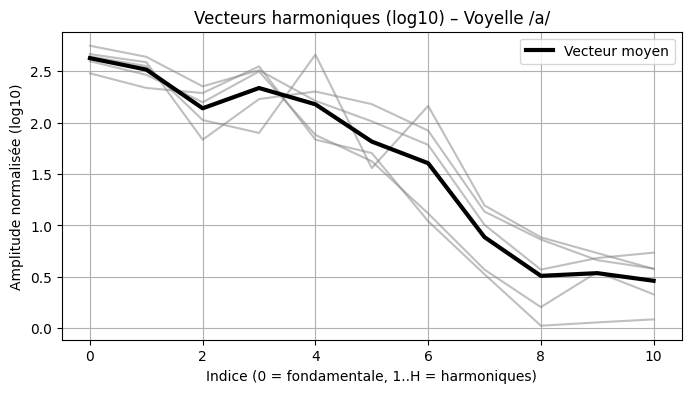

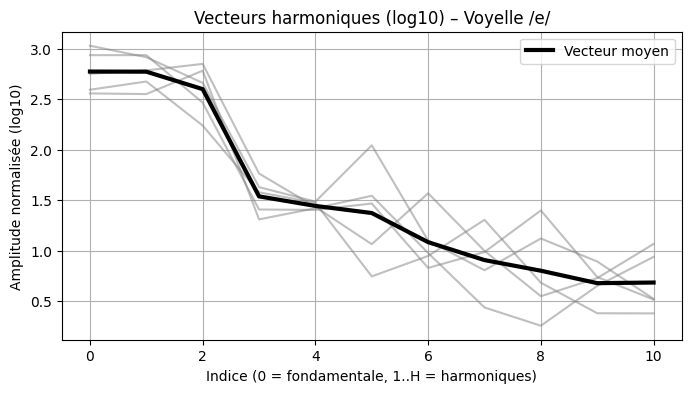

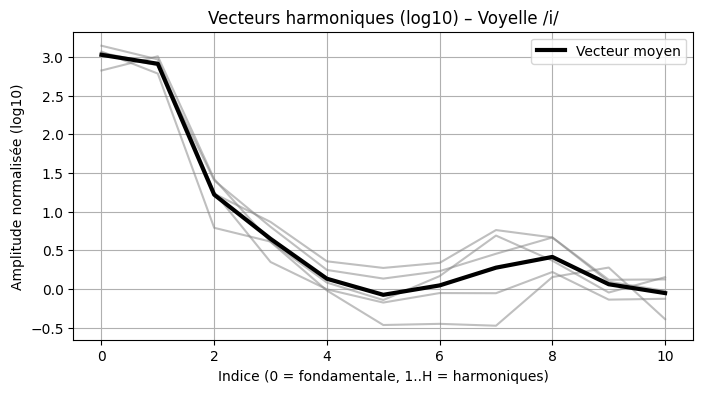

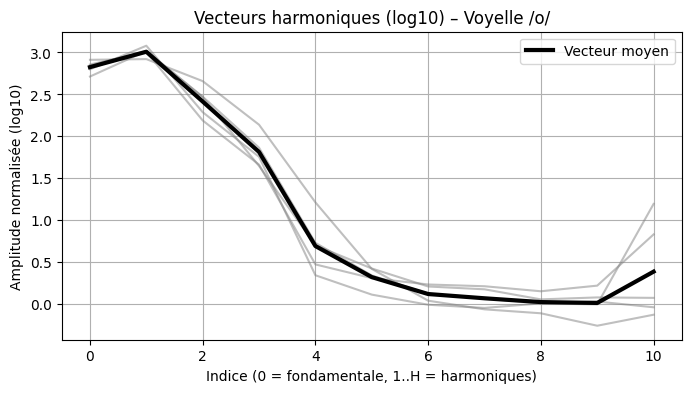

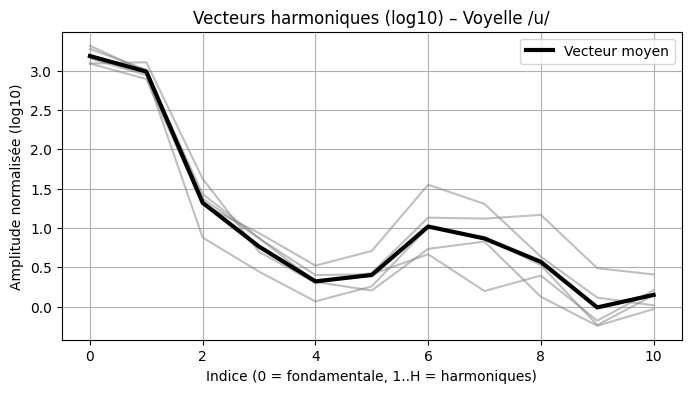

In [20]:
import matplotlib.pyplot as plt

# --------------------------------------
# AFFICHAGE DES VECTEURS + VECTEUR MOYEN
# --------------------------------------

def afficher_vecteurs(voyelle, liste_vecteurs, vecteur_moyen):
    plt.figure(figsize=(8,4))

    # tracer les 5 vecteurs individuels
    for vec in liste_vecteurs:
        plt.plot(vec, alpha=0.5, color="gray")

    # tracer le vecteur moyen
    plt.plot(vecteur_moyen, color="black", linewidth=3, label="Vecteur moyen")

    plt.title(f"Vecteurs harmoniques (log10) – Voyelle /{voyelle}/")
    plt.xlabel("Indice (0 = fondamentale, 1..H = harmoniques)")
    plt.ylabel("Amplitude normalisée (log10)")
    plt.legend()
    plt.grid()
    plt.show()


# Affichage pour chaque voyelle
afficher_vecteurs("a", liste_vecteur_a, vecteur_moyen_a)
afficher_vecteurs("e", liste_vecteur_e, vecteur_moyen_e)
afficher_vecteurs("i", liste_vecteur_i, vecteur_moyen_i)
afficher_vecteurs("o", liste_vecteur_o, vecteur_moyen_o)
afficher_vecteurs("u", liste_vecteur_u, vecteur_moyen_u)


Distances :
a : 8.942649
e : 8.771773
i : 6.842864
o : 7.4503636
u : 7.6350927

>>> La voyelle prédite pour signal_4 est : i


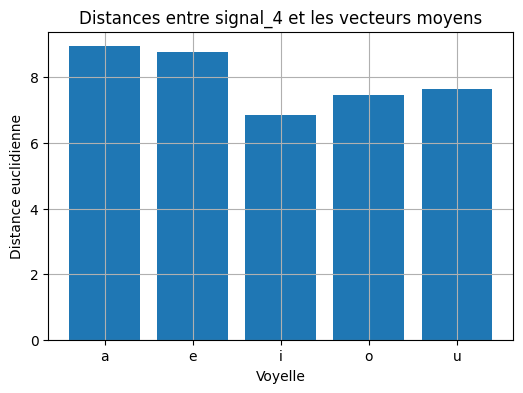

In [21]:
# ============================================
#  DIAPO 4 : CLASSIFICATION DU SIGNAL_4
# ============================================

# Charger signal_4
donnees4 = np.load(f"{DOSSIER_DONNEES}/signal_4.npz")
t4 = donnees4["t"]
s4 = donnees4["s"]

# Fréquence d'échantillonnage
fe4 = 1.0 / (t4[1] - t4[0])

# Centrage
s4_centre = s4 - np.mean(s4)

# FFT
N4 = len(s4_centre)
spectre4 = np.fft.rfft(s4_centre)
frequences4 = np.fft.rfftfreq(N4, d=1.0 / fe4)
amplitude4 = np.abs(spectre4)
amplitude4_norm = amplitude4 / np.max(amplitude4)

# -------------------------------------
# EXTRACTION HARMONIQUE SIGNAL_4
# -------------------------------------

# fondamentale
f0_4 = san.detect_fondamentale(amplitude4_norm, frequences4)

# amplitude fondamentale
idx_f0_4 = np.argmin(np.abs(frequences4 - f0_4))
amp_f0_4 = amplitude4_norm[idx_f0_4]

# H harmoniques
freq_list_4 = [f0_4 * h for h in range(2, H + 2)]
freq_pics_4, amp_pics_4 = san.detect_pics(amplitude4_norm, freq_list_4, frequences4)
amp_pics_4 = np.array(amp_pics_4)

if len(amp_pics_4) < H:
    amp_pics_4 = np.concatenate([amp_pics_4, np.full(H - len(amp_pics_4), 1e-12)])
else:
    amp_pics_4 = amp_pics_4[:H]

# vecteur harmonique du signal_4
eps = 1e-12
vecteur_4 = [np.log10(amp_f0_4 + eps)] + [np.log10(a+eps) for a in amp_pics_4]

# -------------------------------------
#      CLASSIFICATION PAR DISTANCE
# -------------------------------------

import numpy.linalg as LA

distances = {
    "a": LA.norm(vecteur_4 - vecteur_moyen_a),
    "e": LA.norm(vecteur_4 - vecteur_moyen_e),
    "i": LA.norm(vecteur_4 - vecteur_moyen_i),
    "o": LA.norm(vecteur_4 - vecteur_moyen_o),
    "u": LA.norm(vecteur_4 - vecteur_moyen_u)
}

print("\nDistances :")
for v, d in distances.items():
    print(v, ":", d)

# voyelle prédite
voyelle_predite = min(distances, key=distances.get)
print("\n>>> La voyelle prédite pour signal_4 est :", voyelle_predite)

# -------------------------------------
# AFFICAGE BARPLOT
# -------------------------------------
plt.figure(figsize=(6,4))
plt.bar(distances.keys(), distances.values())
plt.title("Distances entre signal_4 et les vecteurs moyens")
plt.xlabel("Voyelle")
plt.ylabel("Distance euclidienne")
plt.grid()
plt.show()